In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import json
import pickle
from lib import data
import Constants
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import GridSearchCV
from collections import defaultdict
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from torch.utils.data import DataLoader
import os
import sys
import matplotlib.pyplot as plt
sys.path.append('../')

## Group Proportions

In [2]:
root_dir = Path('/scratch/hdd001/home/haoran/cxr_bias')
res = {}
for env in ['MIMIC', 'CXP']:
    ds = data.get_dataset(envs = [env], split = None, only_frontal = False)
    res[env] = ds.dataframe.race.value_counts(normalize = True)

In [3]:
df = pd.DataFrame(res)

In [4]:
df.index = df.index.map(Constants.race_mapping)

In [5]:
df.style.format(formatter = '{:.2%}' )

,MIMIC,CXP
White,67.64%,61.09%
Black,18.59%,5.82%
Hispanic,6.41%,1.80%
Asian,3.24%,11.31%
Other,4.12%,19.98%


## Label Proportions

In [6]:
res = {}
for env in ['MIMIC', 'CXP']:
    ds = data.get_dataset(envs = [env], split = None)
    res[env] = ds.dataframe.groupby('race').agg({i: 'mean' for i in Constants.take_labels})

In [7]:
df = pd.concat(res).reset_index().rename(columns = {'level_0' : 'Env'})
df['race'] = df['race'].map(Constants.race_mapping)

In [8]:
df.set_index(['Env', 'race']).style.format(formatter = '{:.2%}' )

## Performance

In [2]:
ress = []
root_dir = Path('/scratch/hdd001/home/haoran/cxr_bias/Normal')
for i in root_dir.glob('**/done'):
    args = json.load((i.parent/'args.json').open('rb'))
    res = pickle.load((i.parent/'results.pkl').open('rb'))
    ress.append({**args, **res})

In [3]:
settings = {
    'no_augment': 'pixel_thres > 0.9 & ~augment',
    'augment': 'pixel_thres > 0.9 & augment',
    'no_augment_bone': 'pixel_thres < 0.9 & ~augment'
}

In [4]:
for setting in settings:
    print(setting)
    df = pd.DataFrame(ress).query(settings[setting]).query(f'target == "race"') 
    eval_metrics = [i for i in list(df.iloc[0]['unaug'].keys()) if i not in ['preds', 'targets'] ]
    for col in eval_metrics:
        if '~augment' not in settings[setting]:
            df[col] = df['aug'].apply(lambda x: x[col])
        else:
            df[col] = df['unaug'].apply(lambda x: x[col])
    df = df.groupby(['domain', 'model']).agg({i: ['mean' ,'std'] for i in df.columns if i in eval_metrics})
    df.columns = ["_".join(pair) if pair[1] != '' else pair[0] for pair in df.columns ]
    for i in eval_metrics:
        df[i] = df[f'{i}_mean'].apply('{:.3f}'.format) + u"\u00B1" + df[f'{i}_std'].apply('{:.3f}'.format)
    display(df[[i + '_mean' for i in eval_metrics]])

no_augment


roc_White_mean  roc_Black_mean  roc_Hispanic_mean  \
domain model                                                                   
CXP    densenet                  0.840455        0.937435           0.821695   
       vision_transformer        0.811319        0.909684           0.793967   
MIMIC  densenet                  0.914766        0.965808           0.835483   
       vision_transformer        0.887986        0.943169           0.793211   
both   densenet                  0.890037        0.966417           0.845015   
       vision_transformer        0.862878        0.947963           0.836486   

                           roc_Asian_mean  roc_Other_mean  
domain model                                               
CXP    densenet                  0.938890        0.706294  
       vision_transformer        0.912038        0.689626  
MIMIC  densenet                  0.962548        0.603154  
       vision_transformer        0.924890        0.606143  
both   densenet                  0.960424        0.770323  
       vision_transformer        0.935256        0.764024

augment


roc_White_mean  roc_Black_mean  roc_Hispanic_mean  \
domain model                                                                   
CXP    densenet                  0.824167        0.920171           0.775459   
       vision_transformer        0.795826        0.909754           0.767470   
MIMIC  densenet                  0.904039        0.953039           0.832301   
       vision_transformer        0.887555        0.934993           0.801731   
both   densenet                  0.865722        0.951303           0.838234   
       vision_transformer        0.849302        0.936923           0.825051   

                           roc_Asian_mean  roc_Other_mean  
domain model                                               
CXP    densenet                  0.923175        0.694444  
       vision_transformer        0.899324        0.674593  
MIMIC  densenet                  0.945740        0.602328  
       vision_transformer        0.910721        0.608830  
both   densenet                  0.942037        0.757329  
       vision_transformer        0.919882        0.755726

no_augment_bone


roc_White_mean  roc_Black_mean  roc_Hispanic_mean  \
domain model                                                                   
CXP    densenet                  0.834632        0.937482           0.826067   
       vision_transformer        0.802095        0.897493           0.791543   
MIMIC  densenet                  0.908923        0.960132           0.833091   
       vision_transformer        0.890915        0.941702           0.810398   
both   vision_transformer        0.856492        0.944900           0.833698   

                           roc_Asian_mean  roc_Other_mean  
domain model                                               
CXP    densenet                  0.928383        0.703943  
       vision_transformer        0.903823        0.680623  
MIMIC  densenet                  0.957192        0.590558  
       vision_transformer        0.910704        0.607253  
both   vision_transformer        0.925775        0.759481

## Race Prediction using Labels

In [5]:
from lib import cxr_preprocess

dfs = {
    'CXP': (cxr_preprocess.preprocess_CXP(pd.read_csv(Constants.df_paths['CXP']['train']), only_frontal = True, return_all_labels = True)),
   'MIMIC': (cxr_preprocess.preprocess_MIMIC(pd.read_csv(Constants.df_paths['MIMIC']['train']), only_frontal = True, return_all_labels = True))
}

In [8]:
labels = ['No Finding', 'Atelectasis', 'Cardiomegaly', 'Effusion',
       'Pneumonia', 'Pneumothorax', 'Consolidation', 'Edema',
       'Enlarged Cardiomediastinum', 'Airspace Opacity', 'Lung Lesion',
       'Pleural Other', 'Fracture', 'Support Devices']

In [9]:
res = {}
for ds, df in dfs.items():
    test_split = int(0.7*df.shape[0])

    target_tr = df['race'][:test_split]
    label_tr = df[labels].iloc[:test_split]

    target_te = df['race'][test_split:]
    label_te = df[labels].iloc[test_split:]
    
    grid = {
    'max_depth': list(range(5))
    }
    clf = XGBClassifier(objective='multi:softprob', n_jobs = -1, random_state = 42)
    cv = GridSearchCV(clf, grid, scoring = 'neg_log_loss', cv = 5, refit = True).fit(label_tr.values, target_tr)

    preds = cv.predict_proba(label_te.values)
    
    res[ds] = {}
    for ind, race in Constants.race_mapping.items():
        target_bin = target_te == ind
        pred = preds[:, ind]
        res[ds][race] = roc_auc_score(target_bin, pred)

In [10]:
pd.DataFrame(res)

,CXP,MIMIC
White,0.520638,0.570927
Black,0.568741,0.607894
Hispanic,0.572577,0.574365
Asian,0.543028,0.561214
Other,0.514454,0.538099


## Race Prediction using Histogram

In [2]:
# for dataset in [['MIMIC'], ['CXP'] ,['MIMIC', 'CXP']]:
dataset = ['MIMIC']
train_ds = data.get_dataset(envs = dataset, split = 'train', only_frontal=False, imagenet_norm=False,
                           subset_label = 'ethnicity')
test_ds = data.get_dataset(envs = dataset, split = 'test', only_frontal=False, imagenet_norm=False,
                           subset_label = 'ethnicity')

def load_data(ds):
    dl = DataLoader(ds, 64, shuffle = True)
    hists, ys = [], []    
    for x, y, metas in tqdm(dl):
        ys.append(y.numpy())
        x = x.float().numpy()[:, 0, :, :]
        for i in range(x.shape[0]):
            hists.append(np.histogram(x[i, :, :].ravel(), bins = 256, range = (0.0, 1.0))[0])
        if len(hists) > 10000:
            break
    return hists, ys
    
train_hists, train_ys = load_data(train_ds)
test_hists, test_ys = load_data(test_ds)

 39%|███▉      | 156/396 [00:35<00:54,  4.37it/s]


In [9]:
train_X = np.vstack(train_hists)
train_Y = np.concatenate(train_ys)

test_X = np.vstack(test_hists)
test_Y = np.concatenate(test_ys)

In [8]:
grid = {
    'max_depth': list(range(7))
}
clf = XGBClassifier(objective='multi:softprob', n_jobs = -1, random_state = 42)

cv = GridSearchCV(clf, grid, scoring = 'neg_log_loss', cv = 5, refit = True).fit(train_X, train_Y)

In [11]:
p = cv.predict_proba(test_X)

In [13]:
res = {}
for ind, race in Constants.race_mapping.items():
    target_bin = test_Y == ind
    pred = p[:, ind]
    res[race] = roc_auc_score(target_bin, pred)

In [18]:
pd.DataFrame({'roc': res})

,roc
Asian,0.597418
Black,0.552927
Hispanic,0.523544
Other,0.527935
White,0.547140


### IFFT

In [2]:
root_dir = Path('/scratch/hdd001/home/haoran/cxr_bias/IFFT')

In [3]:
ress = []
for i in root_dir.glob('**/done'):
    try:
        args = json.load((i.parent/'args.json').open('rb'))
        res = pickle.load((i.parent/'results.pkl').open('rb'))
    except:
        print(i)
    ress.append({**args, **res})

In [4]:
settings = {
    'normal': 'crop_patch_at_end == False & add_noise == False',    
    'crop_only': 'crop_patch_at_end == True & add_noise == False',
    'noise_only': 'crop_patch_at_end == False & add_noise == True',
    'both': 'crop_patch_at_end == True & add_noise == True',
}

normal


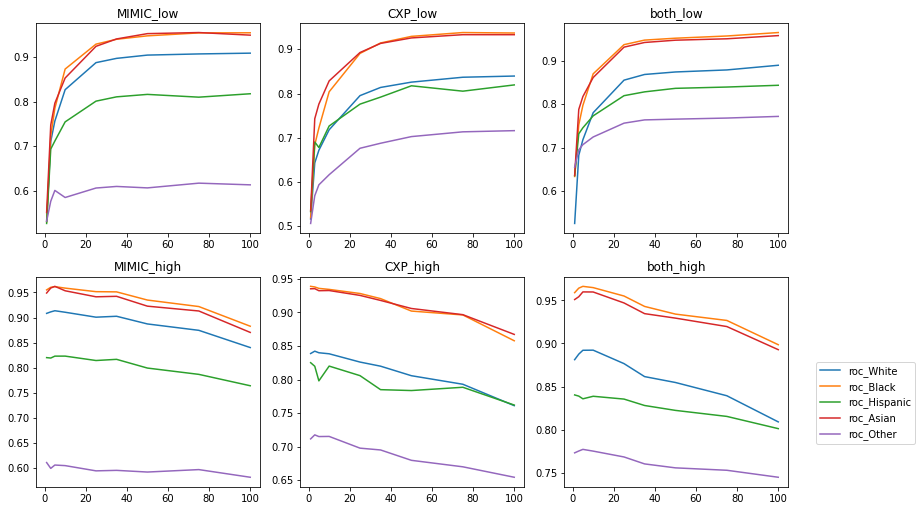

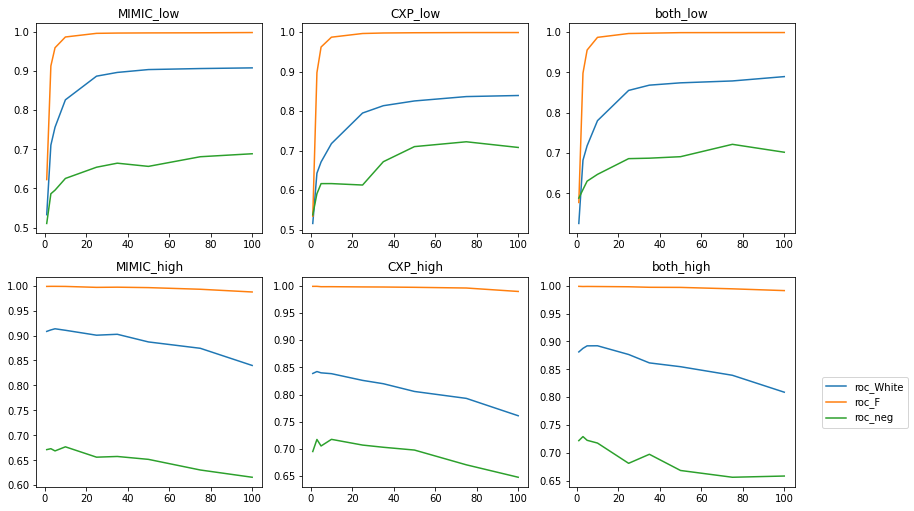

crop_only


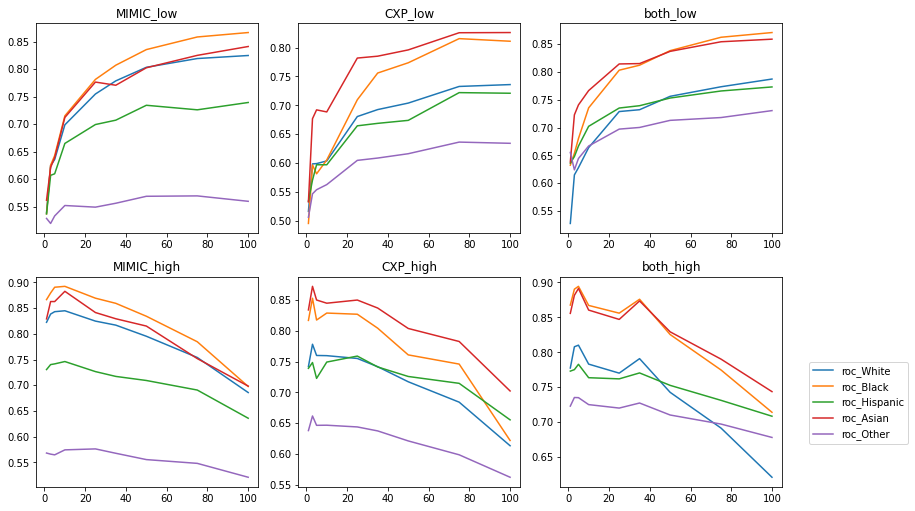

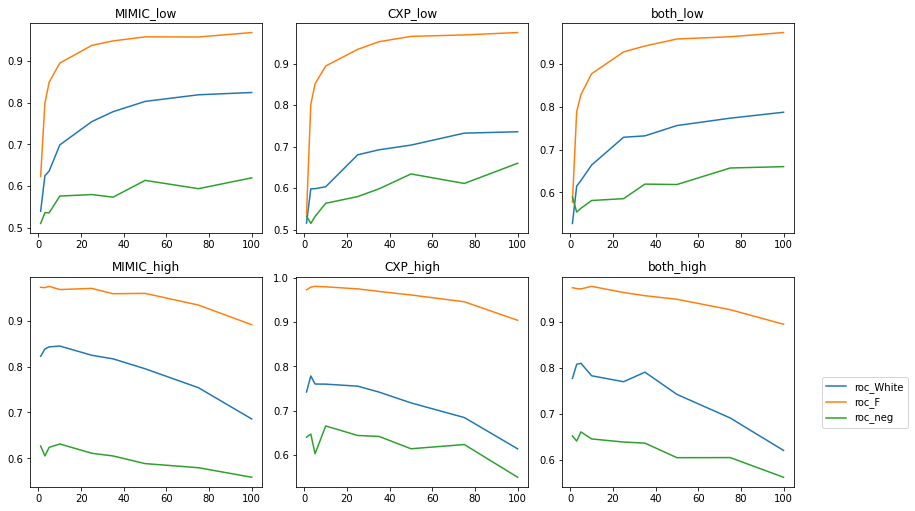

noise_only


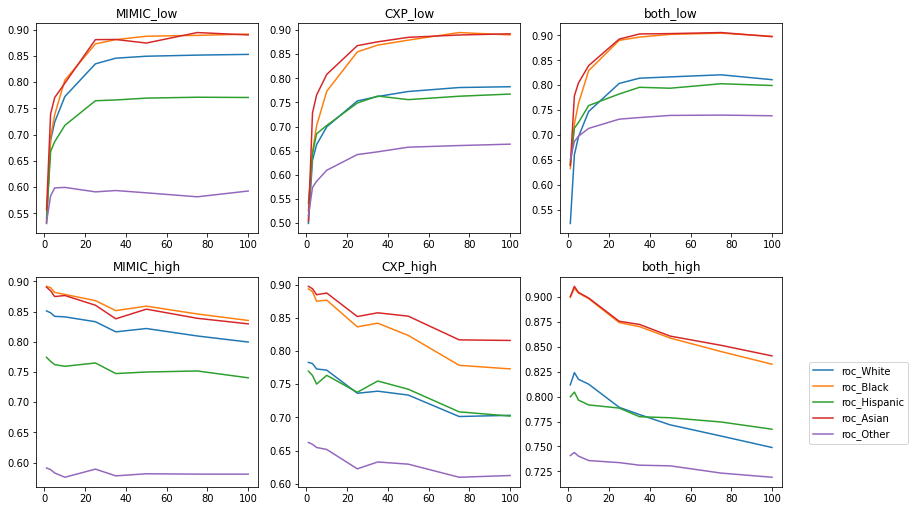

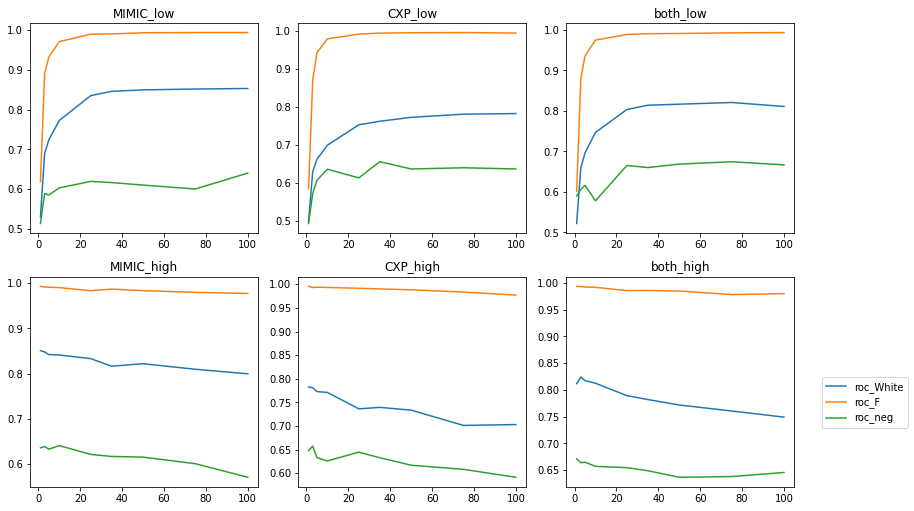

both


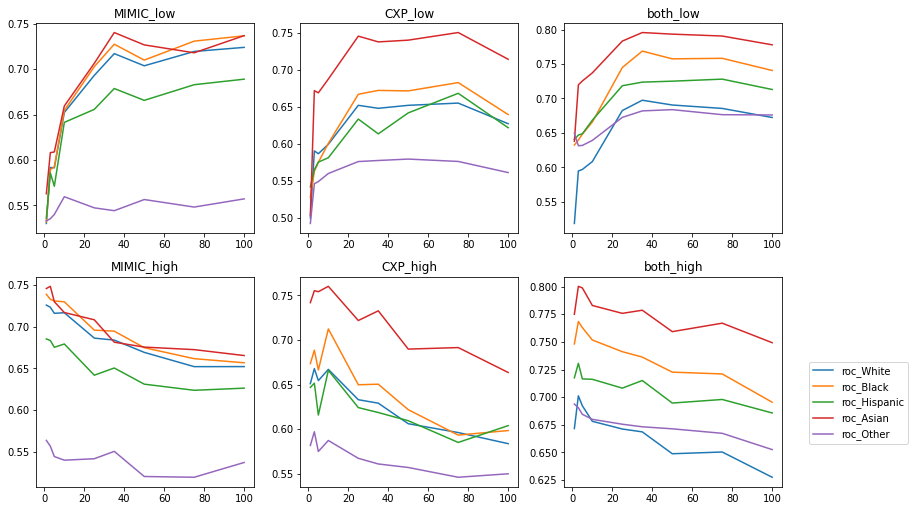

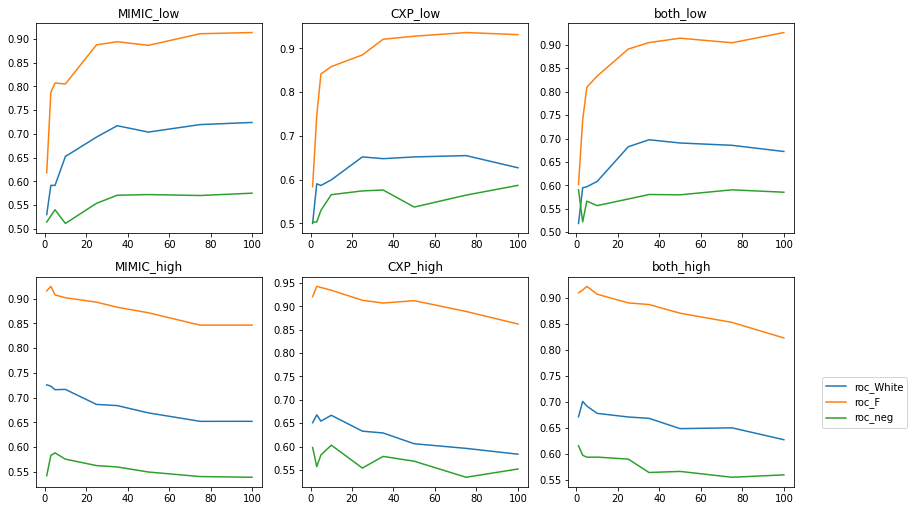

In [5]:
for setting in settings:
    print(setting)
    query = settings[setting]
    df = pd.DataFrame(ress).query(query).query('target == "race"')
    cols = list(df.iloc[0]['unaug'].keys())[:5]
    for col in cols:
        df[col] = df['unaug'].apply(lambda x: x[col])

    df = df.groupby(['domain', 'filter_type', 'filter_thres']).agg({i: ['mean' ,'std'] for i in df.columns if i in cols})
    df.columns = ["_".join(pair) if pair[1] != '' else pair[0] for pair in df.columns ]

    for i in cols:
        df[i] = df[f'{i}_mean'].apply('{:.3f}'.format) + u"\u00B1" + df[f'{i}_std'].apply('{:.3f}'.format)
    df = df.reset_index()
    fig, axs = plt.subplots(nrows = 2, ncols = 3, figsize = (6.4*2, 4.8*1.5))
    for c, domain in enumerate(['MIMIC', 'CXP', 'both']):
        for d, filter_type in enumerate(['low', 'high']):
            ax = axs[d][c]
            df_temp = df.query(f'domain=="{domain}" & filter_type == "{filter_type}"')
            for col in cols:
                ax.plot(df_temp['filter_thres'], df_temp[col+'_mean'], label = col)
            ax.set_title(f'{domain}_{filter_type}')
    handles, labels = ax.get_legend_handles_labels()
    axs[-1][-1].legend(handles = handles, loc='center left', bbox_to_anchor=(1.1, 0.4))  
    plt.tight_layout()
    plt.show()

    fig, axs = plt.subplots(nrows = 2, ncols = 3, figsize = (6.4*2, 4.8*1.5))
    for overall_col in ['race', 'gender', 'Pneumonia']:
        df = pd.DataFrame(ress).query(query).query(f'target == "{overall_col}"')
        cols = [i for i in list(df.iloc[0]['unaug'].keys()) if i not in ['preds', 'targets'] ]
        for col in cols:
            df[col] = df['unaug'].apply(lambda x: x[col])

        df = df.groupby(['domain', 'filter_type', 'filter_thres']).agg({i: ['mean' ,'std'] for i in df.columns if i in cols})
        df.columns = ["_".join(pair) if pair[1] != '' else pair[0] for pair in df.columns ]
        for i in cols:
            df[i] = df[f'{i}_mean'].apply('{:.3f}'.format) + u"\u00B1" + df[f'{i}_std'].apply('{:.3f}'.format)
        df = df.reset_index()    

        for c, domain in enumerate(['MIMIC', 'CXP', 'both']):
            for d, filter_type in enumerate(['low', 'high']):
                ax = axs[d][c]
                df_temp = df.query(f'domain=="{domain}" & filter_type == "{filter_type}"')            
                test = ax.plot(df_temp['filter_thres'], df_temp[cols[0]+'_mean'], label = cols[0])
                ax.set_title(f'{domain}_{filter_type}')
        handles, labels = ax.get_legend_handles_labels()
        axs[-1][-1].legend(handles = handles, loc='center left', bbox_to_anchor=(1.1, 0.4))  
        plt.tight_layout() 
    plt.show()

## New Graphs (Apr 11)

In [2]:
root_dir = Path('/scratch/hdd001/home/haoran/cxr_bias/IFFT')

ress = []
for i in root_dir.glob('**/done'):
    try:
        args = json.load((i.parent/'args.json').open('rb'))
        res = pickle.load((i.parent/'results.pkl').open('rb'))
    except:
        print(i)
    ress.append({**args, **res})
    
settings = {
    'normal': 'crop_patch_at_end == False & add_noise == False',    
}

normal


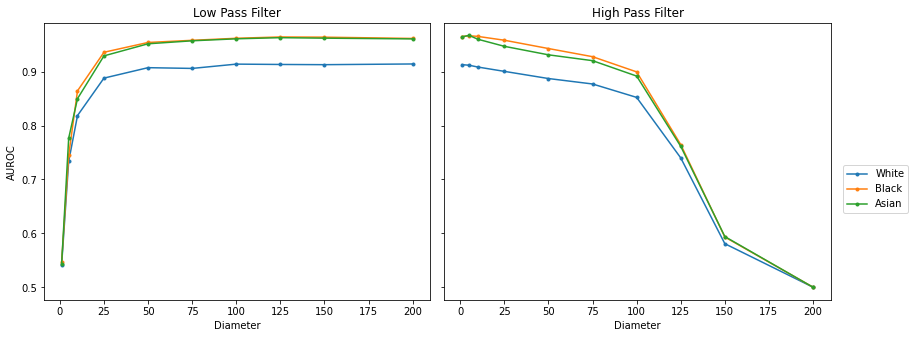

In [3]:
for setting in settings:
    print(setting)
    query = settings[setting]
    df = pd.DataFrame(ress).query(query).query('target == "race"')
    cols = list(df.iloc[0]['unaug'].keys())[:5]
    for col in cols:
        df[col] = df['unaug'].apply(lambda x: x[col])

    df = df.groupby(['domain', 'filter_type', 'filter_thres']).agg({i: ['mean' ,'std'] for i in df.columns if i in cols})
    df.columns = ["_".join(pair) if pair[1] != '' else pair[0] for pair in df.columns ]

    for i in cols:
        df[i] = df[f'{i}_mean'].apply('{:.3f}'.format) + u"\u00B1" + df[f'{i}_std'].apply('{:.3f}'.format)
    df = df.reset_index()
    # fig, axs = plt.subplots(nrows = 2, ncols = 1, figsize = (6.4*1.5, 4.8*1.5))
    fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (6.4*2.0, 4.8*1.0), sharey = True)
    for c, domain in enumerate(['MIMIC']):
    # for c, domain in enumerate(['MIMIC', 'CXP', 'both']):
        for d, filter_type in enumerate(['low', 'high']):
            ax = axs[d]
            filter_mapping = {'low': 'Low Pass Filter', 'high': 'High Pass Filter'}
            df_temp = df.query(f'domain=="{domain}" & filter_type == "{filter_type}"')
            for col in cols:
                col_mapping = {'roc_' + i: i for i in ('White', 'Black', 'Asian')}
                if col in ['roc_White', 'roc_Black', 'roc_Asian']:
                    ax.plot(df_temp['filter_thres'], df_temp[col+'_mean'], '.-', label = col_mapping[col])
            # ax.set_title(f'{domain} {filter_mapping[filter_type]}')
            ax.set_title(f'{filter_mapping[filter_type]}')
            ax.set_xlabel('Diameter')
            if d == 0:
                ax.set_ylabel('AUROC')
    handles, labels = ax.get_legend_handles_labels()
    axs[-1].legend(handles = handles, loc='center left', bbox_to_anchor=(1.02, 0.4))  
    plt.tight_layout()
    plt.savefig('filters_output.png', dpi = 300)
    plt.show()

#     fig, axs = plt.subplots(nrows = 2, ncols = 3, figsize = (6.4*2, 4.8*1.5))
#     for overall_col in ['race', 'gender', 'Pneumonia']:
#         df = pd.DataFrame(ress).query(query).query(f'target == "{overall_col}"')
#         cols = [i for i in list(df.iloc[0]['unaug'].keys()) if i not in ['preds', 'targets'] ]
#         for col in cols:
#             df[col] = df['unaug'].apply(lambda x: x[col])

#         df = df.groupby(['domain', 'filter_type', 'filter_thres']).agg({i: ['mean' ,'std'] for i in df.columns if i in cols})
#         df.columns = ["_".join(pair) if pair[1] != '' else pair[0] for pair in df.columns ]
#         for i in cols:
#             df[i] = df[f'{i}_mean'].apply('{:.3f}'.format) + u"\u00B1" + df[f'{i}_std'].apply('{:.3f}'.format)
#         df = df.reset_index()    

#         for c, domain in enumerate(['MIMIC', 'CXP', 'both']):
#             for d, filter_type in enumerate(['low', 'high']):
#                 ax = axs[d][c]
#                 df_temp = df.query(f'domain=="{domain}" & filter_type == "{filter_type}"')            
#                 test = ax.plot(df_temp['filter_thres'], df_temp[cols[0]+'_mean'], label = cols[0])
#                 ax.set_title(f'{domain}_{filter_type}')
#         handles, labels = ax.get_legend_handles_labels()
#         axs[-1][-1].legend(handles = handles, loc='center left', bbox_to_anchor=(1.1, 0.4))  
#         plt.tight_layout() 
#     plt.show()

# Patches (Apr 11)

In [5]:
ress = []
root_dir = Path('/scratch/hdd001/home/haoran/cxr_bias/IFFTPatched')
for i in root_dir.glob('**/done'):
    args = json.load((i.parent/'args.json').open('rb'))
    res = pickle.load((i.parent/'results.pkl').open('rb'))
    ress.append({**args, **res})
df = pd.DataFrame(ress)
df = df.dropna(subset = ['patch_ind'])

df = df[df.target == 'race']

cols = list(df.iloc[0]['unaug'].keys())[:5]

for col in cols:
    df[col] = df['unaug'].apply(lambda x: x[col])

df = df.groupby(['domain', 'filter_type', 'filter_thres', 'patched', 'patch_ind', 'data_type']).agg({i: ['mean' ,'std'] for i in df.columns if i in cols})
df.columns = ["_".join(pair) if pair[1] != '' else pair[0] for pair in df.columns ]

df = df.reset_index()

df = df[['patched', 'patch_ind', 'data_type', 'roc_White_mean']]
df['patch_ind'] = df['patch_ind'].astype(int)

df['row'] = df['patch_ind']//3
df['col'] = df['patch_ind']%3

In [6]:
for p in ['invpatch', 'patch']:
    temp = df[df.patched == p]
    display(temp.pivot_table(index = ['row', 'data_type'], columns = 'col', values = 'roc_White_mean'))

col                   0         1         2
row data_type                              
0   ifft       0.837827  0.831857  0.832455
    normal     0.907579  0.897285  0.910739
1   ifft       0.842846  0.830886  0.831539
    normal     0.908756  0.906329  0.907855
2   ifft       0.850867       NaN  0.840444
    normal     0.911225  0.911054  0.911805

col                   0         1         2
row data_type                              
0   ifft       0.730235  0.715316       NaN
    normal     0.867576  0.883526  0.874176
1   ifft       0.577296  0.686375  0.664959
    normal     0.600725  0.824158  0.839283
2   ifft       0.700808  0.585235  0.635367
    normal     0.821109  0.563038  0.751928

## Notch/Bandpass Filter

In [4]:
ress = []
root_dir = Path('/scratch/hdd001/home/haoran/cxr_bias/IFFTNotchBandpass/')
for i in root_dir.glob('**/done'):
    args = json.load((i.parent/'args.json').open('rb'))
    res = pickle.load((i.parent/'results.pkl').open('rb'))
    ress.append({**args, **res})
df = pd.DataFrame(ress)

In [5]:
df = df[df.target == 'race']
df = df[df.filter_type == 'notch']

cols = list(df.iloc[0]['unaug'].keys())[:5]

for col in cols:
    df[col] = df['unaug'].apply(lambda x: x[col])

df = df.groupby(['domain', 'filter_thres2', 'filter_thres']).agg({i: ['mean' ,'std'] for i in df.columns if i in cols})
df.columns = ["_".join(pair) if pair[1] != '' else pair[0] for pair in df.columns ]

df = df.reset_index()

In [6]:
df.pivot_table(values = 'roc_White_mean', index = 'filter_thres', columns = 'filter_thres2')

filter_thres2,25.0,50.0,75.0,100.0,125.0,150.0
filter_thres,,,,,,
10.0,0.901384,0.889483,0.872393,0.854923,0.824163,0.817387
25.0,NaN,0.904101,0.899816,0.894264,0.890835,0.891066
50.0,NaN,NaN,0.909350,0.911338,0.908235,0.904740
75.0,NaN,NaN,NaN,0.910561,0.910839,0.909151
100.0,NaN,NaN,NaN,NaN,0.914241,0.911902
125.0,NaN,NaN,NaN,NaN,NaN,0.914512
